# [The Haldane gap](@id demo_haldane)

In this tutorial we will calculate the Haldane gap (the energy gap in the ``S = 1`` Heisenberg model) in two different ways.
To follow the tutorial you need the following packages:

In [2]:
using MPSKit, MPSKitModels, TensorKit, Plots, Polynomials
import TensorOperations; TensorOperations.disable_cache(); # hide

The Heisenberg model is defined by the following hamiltonian:

```math
H = -J∑_{⟨i,j⟩} (X_i X_j + Y_i Y_j + Z_i Z_j)
```

This hamiltonian has an SU(2) symmetry, which we can enforce by using SU(2)-symmetric tensors:

In [3]:
H = xxx(ComplexF64, SU₂; spin=1, J=-1);

## Finite size extrapolation

We can start the analysis using finite-size methods.
The groundstate of this model can be approximated using finite MPS through the use of DMRG.

The typical way to find excited states is to minimize the energy while adding an error term
$$λ \left|gs\right> \left< gs\right|$$
Here we will instead use the [quasiparticle ansatz](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.111.080401).

In Steven White's original DMRG paper it was remarked that the ``S = 1`` excitations correspond to edge states, and that one should define the Haldane gap as the difference in energy between the ``S = 2`` and ``S = 1`` states.
This can be done as follows.

In [4]:
L = 10
physical_space = Rep[SU₂](1 => 1)
virtual_space = Rep[SU₂](0 => 15, 1 => 15, 2 => 10, 3 => 5)
ψ₀ = FiniteMPS(rand, ComplexF64, L, physical_space, virtual_space)
ψ, envs, delta = find_groundstate(ψ₀, H, DMRG(; verbose=false))
E₀ = real.(expectation_value(ψ, H))
En_1, st_1 = excitations(H, QuasiparticleAnsatz(), ψ, envs; sector=SU₂(1))
En_2, st_2 = excitations(H, QuasiparticleAnsatz(), ψ, envs; sector=SU₂(2))
ΔE_finite = real(En_2[1] - En_1[1])

0.7655030891776688

We can go even further and doublecheck the claim that ``S = 1`` is an edge excitation, by plotting the energy density.

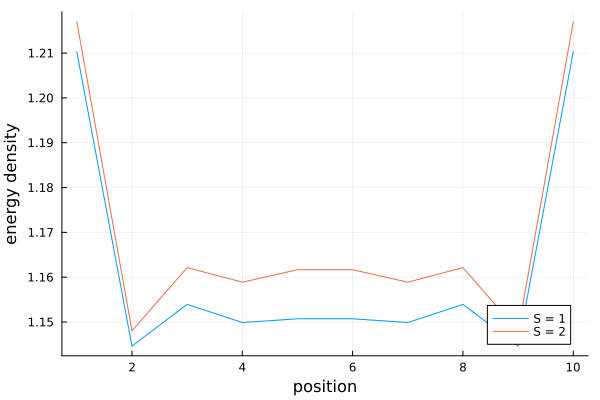

In [5]:
p_density = plot(; xaxis="position", yaxis="energy density")
excited_1 = convert(FiniteMPS, st_1[1])
excited_2 = convert(FiniteMPS, st_2[1])
plot!(p_density, real.(expectation_value(excited_1, H) .- E₀) ./ L; label="S = 1")
plot!(p_density, real.(expectation_value(excited_2, H) .- E₀) ./ L; label="S = 2")

Finally, we can obtain a value for the Haldane gap by extrapolating our results for different system sizes.

In [6]:
Ls = 5:5:15
ΔEs = map(Ls) do L
    ψ₀ = FiniteMPS(rand, ComplexF64, L, physical_space, virtual_space)
    ψ, envs, delta = find_groundstate(ψ₀, H, DMRG(; verbose=false))
    En_1, st_1 = excitations(H, QuasiparticleAnsatz(), ψ, envs; sector=SU₂(1))
    En_2, st_2 = excitations(H, QuasiparticleAnsatz(), ψ, envs; sector=SU₂(2))
    return real(En_2[1] - En_1[1])
end

In [ ]:
f = fit(Ls .^ (-2), ΔEs, 1)
ΔE_extrapolated = f.coeffs[1]

In [ ]:
p_size_extrapolation = plot(; xaxis="L^(-2)", yaxis="ΔE",
    xlims=(0, 0.015))
plot!(p_size_extrapolation, Ls .^ (-2), ΔEs;
    seriestype=:scatter, label="numerical")
plot!(p_size_extrapolation, x -> f(x); label="fit")

## Thermodynamic limit

A much nicer way of obtaining the Haldane gap is by working directly in the thermodynamic limit.
As was already hinted at by the edge modes, this model is in a non-trivial SPT phase.
Thus, care must be taken when selecting the symmetry sectors.
The groundstate has half-integer edge modes, thus the virtual spaces must also all carry half-integer charges.

In contrast with the finite size case, we now should specify a momentum label to the excitations.
This way, it is possible to scan the dispersion relation over the entire momentum space.

In [ ]:
virtual_space_inf = Rep[SU₂](1 // 2 => 20, 3 // 2 => 20, 5 // 2 => 10, 7 // 2 => 10,
    9 // 2 => 5)
ψ₀_inf = InfiniteMPS([physical_space], [virtual_space_inf])
ψ_inf, envs_inf, delta_inf = find_groundstate(ψ₀_inf, H)

kspace = range(0, π, 16)
Es, _ = excitations(H, QuasiparticleAnsatz(), kspace, ψ_inf, envs_inf; sector=SU₂(1))

ΔE, idx = findmin(real.(Es))
println("minimum @k = $(kspace[idx]):\t ΔE = $(ΔE)")

In [ ]:
plot(kspace, real.(Es); xaxis="momentum", yaxis="ΔE", label="S = 1")